**Team**:
    @Anni Cai, @Leon Man (Ka Wa Man) , @Qiongqiong Lin, @Wanqiu Zheng 

# Abstract

**1.0. X variables we created:**
********************
*   **is_womens_clothing**: bool, 1 - Yes, 0 - NO
*   **is_men_clothing**: bool, 1 - Yes, 0 - NO
*   **origins**: enum, indicate which country a product was produced
*   **Product Categories**: enum, indicate to which product categories (e.g., tops, bottoms and etc.) a product belongs
*   **Colors**: enum, number of colors that a product has 
*   **Materials**: enum, the type of materials by which a product was produced
*   **IS_SLIM_FIT**: bool, 1 - Yes, 0 - NO
*   **IS_RELAX_FIT**: bool, 1 - Yes, 0 - NO
*   **IS_DRY_CLEAN**: bool, 1 - Yes, 0 - NO
*   **model_size**: enum, the size that a brand model was wearing in `description`
*   **product active**: bool, 1 - Yes, 0 - NO
*   **quarter** enum = [1,2,3,4], the number of quarter indicates in which quarter of a year the product was created
*   **product_creation_speed** float, the number indicates the rank of velocity of product creation, the lower the rank, the faster a brand will launch its clothing prducts or more frequent this brand's product was collected by Behold
*   **product_description embedding**: embedding size = 200
*   **brand_name doc2vec embedding**: embedding size = 6 
*   **Flesh-Kincaid Grade of `brand_name` and `product_descr`**: float, indicates the readability of `product descr` and `brand_name`. The higher the value, the more complex the document to read
*   **Gunning-Fog Grade of `brand_name` and `product_descr`**: float, indicates the readability of `product descr` and `brand_name`. The higher the value, the more complex the document to read

**2.0. Data Cleaning:**
********************
- For categorical variables (variable type: enum), one-hot encoding was applied to create dummy variables
- new new line character `\n` will be removed from the entire dataset 
- Stopwords removal and lemmatization will be conducted on `brand_name` and `product_descr` for doc2vec. However, for calculating `Flesh-Kincaid` and `Gunning-Fog`, these operations are needed. The reason why we conducted text cleaning before doc2vec embedding is the explanatory power of models were improved after removing stopwords and punctuations from them.

**3.0. Y variables:**
********************
*   We group the most frequent 50 brands and classify the remaining others as `Others`
*   Therefore, our benchmark is 15%, and optimal threshold is 50%

**4.0. Models:**
********************
The reason why we prefer tree-based models are 1) Tree-based models are robust to variables with different scale. People do not have to normalize data to make it work in a high dimension space. 2) Tree-base models can tell us which predictors have the highest informmation gain. This will be critical for fine-tuning our models. 3) tree-based is also robust to high dimension datasets. Even if we did not perform dimensionality reduction, it can still achieve expected performance. For those variables with low predictive power, tree-based models will simply put them on the sideline and do not use them to make splits. 4) tree-base models are fast to train than most other models in our experimentation.

*   **Random Forest Classifier**: oob_score is surprisingly high. Maybe cross validation can reveal its true performance
*   **Hist Gradient Boosting Classifer**: the best model based on the testing set, but it's slow to train
*   **Ada Boost Classifier**: the model didn't perform well on the testing set, would not take into further consideration.
*   **KNeighbors Classifier**: did a fair job on the testing set, could be an option to go for

**5.0. Our final pick of the model**
********************
Hist Gradient Boosting Classifer: it delivers the best performance throughout cross validation process, also it is much faster to train than RNN model. The average accuracy score for Hist Gradient Boosting Classifer is 70.4%. Please note the cross validation of `Hist Gradient Boosting Classifer` will be very slow.

















In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

In [2]:
# we only need products data 
products = pd.read_excel('Behold+product+data+04262021.xlsx')

In [3]:
## Leon Set
# from google.colab import drive
# drive.mount('/content/drive')

# brands = pd.read_csv('/content/drive/MyDrive/DSO 560/Project/behold_brands USC.csv')
# products = pd.read_excel("/content/drive/MyDrive/DSO 560/Project/Behold+product+data+04262021.xlsx")
# outfits = pd.read_csv("/content/drive/MyDrive/DSO 560/Project/outfit_combinations USC.csv")
# tags = pd.read_csv('/content/drive/MyDrive/DSO 560/Project/usc_additional_tags USC.csv')

In [4]:
# remove brand_canonical_url as requested since it contains brand information
products = products.filter(['product_id', 'brand', 'brand_category', 'name', 'details',
       'created_at', 'description', 'brand_description',
       'brand_name', 'product_active'])

# EDA

In [5]:
brands.head(3)

,brand_id,brand,brand_value,bio,quote,quote_attribute,intro,lifestyle_copy,short_bio,listing_bio
0,01ESKR0CH2KYC7KBNTN0S38EQA,Mari Giudicelli,Handmade / Artisan Crafted,NaN,NaN,NaN,NaN,NaN,NaN,"Behold Mari Giudicelli! This Brazilian shoe designer is a maven of style, and her designs are packed with easy-going elegance. You'll want to pair these covet worthy shoes with every outfit."
1,01ESKR0CH2KYC7KBNTN0S38EQA,Mari Giudicelli,Sustainable,NaN,NaN,NaN,NaN,NaN,NaN,"Behold Mari Giudicelli! This Brazilian shoe designer is a maven of style, and her designs are packed with easy-going elegance. You'll want to pair these covet worthy shoes with every outfit."
2,01ESKR0CH2KYC7KBNTN0S38EQA,Mari Giudicelli,Women Owned,NaN,NaN,NaN,NaN,NaN,NaN,"Behold Mari Giudicelli! This Brazilian shoe designer is a maven of style, and her designs are packed with easy-going elegance. You'll want to pair these covet worthy shoes with every outfit."


In [6]:
brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand_id         162 non-null    object
 1   brand            162 non-null    object
 2   brand_value      154 non-null    object
 3   bio              157 non-null    object
 4   quote            157 non-null    object
 5   quote_attribute  154 non-null    object
 6   intro            154 non-null    object
 7   lifestyle_copy   156 non-null    object
 8   short_bio        157 non-null    object
 9   listing_bio      157 non-null    object
dtypes: object(10)
memory usage: 12.8+ KB


In [7]:
products.head(3)

,product_id,brand,brand_category,name,details,created_at,description,brand_description,brand_name,product_active
0,01EX0PN4J9WRNZH5F93YEX6QAF,Two,Unknown,Khadi Stripe Shirt-our signature shirt,NaN,2021-01-27 01:17:19.305 UTC,"Our signature khadi shirt\navailable in black and white\nEasy to wear from beach to city. We promise this top will be your go-to warm\nweather item. Perfect under a blazer. Hand loomed woven stripe in khadi cotton.\n Slightly sheer and gets softer with every wash. Ships First week of April\nCOLOR: WHITE OR BLACK\n— Length 27"" and Width 26.5"" — One size fits most — Grid khadi cotton","Our signature khadi shirt\n\navailable in black and white\n\nEasy to wear from beach to city. We promise this top will be your go-to warm\nweather item. Perfect under a blazer. Hand loomed woven stripe in khadi cotton.\n Slightly sheer and gets softer with every wash. Ships First week of April\n\n\nCOLOR: WHITE OR BLACK\n\n— Length 27"" and Width 26.5"" — One size fits most — Grid khadi cotton",Khadi Stripe Shirt-our signature shirt,True
1,01F0C4SKZV6YXS3265JMC39NXW,Collina Strada,Unknown,RUFFLE MARKET DRESS LOOPY PINK SISTINE TOMATO,NaN,2021-03-09 18:43:10.457 UTC,Mid-length dress with ruffles and adjustable straps. Bias cut. Side seam\ninvisible zipper\nMade in New York\nModel wears size small\n100% Rose sylk\nRose sylk is an organic cellulose fiber made from the natural waste of rose\nbushes and stems.,Mid-length dress with ruffles and adjustable straps. Bias cut. Side seam\ninvisible zipper. \n\nMade in New York\n\nModel wears size small\n\n \n\n100% Rose sylk\n\nRose sylk is an organic cellulose fiber made from the natural waste of rose\nbushes and stems.,RUFFLE MARKET DRESS LOOPY PINK SISTINE TOMATO,True
2,01EY4Y1BW8VZW51BWG5VZY82XW,Cariuma,Unknown,IBI Slip On Raw Red Knit Sneaker Women,NaN,2021-02-10 02:58:59.591 UTC,IBI Slip On Raw Red Knit Sneaker Women,IBI Slip On Raw Red Knit Sneaker Women,IBI Slip On Raw Red Knit Sneaker Women,False


In [8]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61355 entries, 0 to 61354
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   product_id         61355 non-null  object
 1   brand              61355 non-null  object
 2   brand_category     60896 non-null  object
 3   name               61354 non-null  object
 4   details            9200 non-null   object
 5   created_at         61355 non-null  object
 6   description        51238 non-null  object
 7   brand_description  51234 non-null  object
 8   brand_name         61354 non-null  object
 9   product_active     61355 non-null  bool  
dtypes: bool(1), object(9)
memory usage: 4.3+ MB


In [9]:
outfits.head(3)

,outfit_id,product_id,outfit_item_type,brand,product_full_name
0,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2P5H24WK0HTK4R0A1,bottom,Eileen Fisher,Slim Knit Skirt
1,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2PEPWFTT7RMP5AA1T,top,Eileen Fisher,Rib Mock Neck Tank
2,01DDBHC62ES5K80P0KYJ56AM2T,01DMBRYVA2S5T9W793F4CY41HE,accessory1,kate spade new york,medium margaux leather satchel


In [10]:
outfits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5291 entries, 0 to 5290
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   outfit_id          5291 non-null   object
 1   product_id         5291 non-null   object
 2   outfit_item_type   5291 non-null   object
 3   brand              5291 non-null   object
 4   product_full_name  5291 non-null   object
dtypes: object(5)
memory usage: 206.8+ KB


In [11]:
tags.head(3)

,product_id,product_color_id,attribute_name,attribute_value
0,01E5ZXP5H0BTEZT9QD2HRZJ47A,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,linenblend
1,01E5ZXP5H0BTEZT9QD2HRZJ47A,01E5ZXP5JCREDC7WJVMWHK5Q40,materialclothing,cottonblend
2,01E5ZXP5H0BTEZT9QD2HRZJ47A,01E5ZXP5JCREDC7WJVMWHK5Q40,style,modern


In [12]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97420 entries, 0 to 97419
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_id        97420 non-null  object
 1   product_color_id  97420 non-null  object
 2   attribute_name    97420 non-null  object
 3   attribute_value   97420 non-null  object
dtypes: object(4)
memory usage: 3.0+ MB


# Data Cleaning
- In this cell, we want to remove new line "\n" since just in case that it was unnecessarily tokenized for text analysis

In [13]:
# leave product_description as backup datacolumn
descriptions = products['description']

def newline_replacer(text):
    return re.sub(r'\n',' ',text).strip()

# speed up the loop over each column and remove the new line symbol "\n"
for col in ['name', 'description', 'brand_description', 'brand_name']:
    value_col = products[col].apply(lambda x: newline_replacer(str(x)))
    products[col] = value_col

products.head(3)

,product_id,brand,brand_category,name,details,created_at,description,brand_description,brand_name,product_active
0,01EX0PN4J9WRNZH5F93YEX6QAF,Two,Unknown,Khadi Stripe Shirt-our signature shirt,NaN,2021-01-27 01:17:19.305 UTC,"Our signature khadi shirt available in black and white Easy to wear from beach to city. We promise this top will be your go-to warm weather item. Perfect under a blazer. Hand loomed woven stripe in khadi cotton. Slightly sheer and gets softer with every wash. Ships First week of April COLOR: WHITE OR BLACK — Length 27"" and Width 26.5"" — One size fits most — Grid khadi cotton","Our signature khadi shirt available in black and white Easy to wear from beach to city. We promise this top will be your go-to warm weather item. Perfect under a blazer. Hand loomed woven stripe in khadi cotton. Slightly sheer and gets softer with every wash. Ships First week of April COLOR: WHITE OR BLACK — Length 27"" and Width 26.5"" — One size fits most — Grid khadi cotton",Khadi Stripe Shirt-our signature shirt,True
1,01F0C4SKZV6YXS3265JMC39NXW,Collina Strada,Unknown,RUFFLE MARKET DRESS LOOPY PINK SISTINE TOMATO,NaN,2021-03-09 18:43:10.457 UTC,Mid-length dress with ruffles and adjustable straps. Bias cut. Side seam invisible zipper Made in New York Model wears size small 100% Rose sylk Rose sylk is an organic cellulose fiber made from the natural waste of rose bushes and stems.,Mid-length dress with ruffles and adjustable straps. Bias cut. Side seam invisible zipper. Made in New York Model wears size small 100% Rose sylk Rose sylk is an organic cellulose fiber made from the natural waste of rose bushes and stems.,RUFFLE MARKET DRESS LOOPY PINK SISTINE TOMATO,True
2,01EY4Y1BW8VZW51BWG5VZY82XW,Cariuma,Unknown,IBI Slip On Raw Red Knit Sneaker Women,NaN,2021-02-10 02:58:59.591 UTC,IBI Slip On Raw Red Knit Sneaker Women,IBI Slip On Raw Red Knit Sneaker Women,IBI Slip On Raw Red Knit Sneaker Women,False


# Feature Engineering

## time-base variable 1:  the quarter the product was created

- we know that the fashion and style of clothing would change rapidly from quarter to quarter in order to cater for customer's fast-changing fashion appetite. We want to extract the quarter number to see it could help to calssify the brand_name. 


In [36]:
datetime = pd.to_datetime(products['created_at'],infer_datetime_format=True, utc=True)

In [64]:
products['created_at'] = datetime
products['quarter'] = datetime.dt.quarter

In [65]:
# We can see that, in the third quarter, the number of product creations was the highest relative to the other quarters
datetime.dt.quarter.value_counts()

3    21737
4    16564
1    14662
2     8392
Name: created_at, dtype: int64

## time-base variable 2:  the number of hours has passed since the last product creation

- The velocity of product creation will signify a fashion retailer's corporate culture and mission. If a brand can create a product rapidly, it will help a fashion brand get hits and market shares from customers much easier than the brand which react slowly to the market. Therefore this predictor will help us distinguish `fast fashion brands` and `sluggish brands`.

- Probably this `created_at` just indicates the timestamp when products were entered into Behold product management system. It is still worth to try but may lose its real business meaning in our context. However, as long as the `created_at` is correlated with the real product creation timestamp (after all, new clothing products must be designed and rolled out first before they are collected and managed by Behold) and time lapse between real product launch and product entry created at the  Behold system is relatively constant, it is still acceptable in this business case.

In [66]:
# create an empty database
time_speed = products[['brand','created_at']]

# create date value for comparison
time_speed['date'] = datetime.dt.date

# create data copy 
time_speed_1 = time_speed.copy()

In [67]:
# sort value based on brand and created at so that we can assign processed values back to the dataframe
time_speed = time_speed.sort_values(by=['brand','created_at'])

# create one day time lag within each brand groupping
time_speed['last_product'] = time_speed.sort_values(by=['brand','created_at']).groupby('brand')['created_at'].shift()

In [117]:
# if the produt did not has any values, we assume its last procut creation was the median value of the entire distribution
time_interval  = (time_speed['created_at'] - time_speed['last_product']).astype('timedelta64[s]')

# fill in the median and rank the rows so as to make it more robust to outliers
time_interval_cleaned = time_interval.fillna(time_interval.median()).rank(method='dense',ascending =True)

products['product_creation_speed'] = time_interval_cleaned

## Gender Target: 
- is_women_clothing: Binary {1: Yes, 0: No}
- is_men_clothing: Binary {1: Yes, 0: No}
- In our datasets some products target male customers specifically. Before modeling, this part of rows will be removed and we just focus on female clothing products. Also, we know that there must be a better way to label male and female products e.g. model-based or rule-based. In this case, our team think excluding products that explicitly contain male-related keywords would be a more feasible approach rather than just selecting female-labeled prodcuts as products without specifying for women only excplicitly do not necessarily mean it is not for women.

In [15]:
# Search the keywords in all columns to see if they contain women-related keywords
products['is_womens_clothing'] = products[['description','brand_name']].apply(lambda x: x.astype(str).str.\
                                    findall(r'\b(woman|women|girls?|females?|lady|ladies|unisex|women\'s|woman\'s)\b', re.IGNORECASE).any(), axis=1)

# Transform the list-like results into binary outcomes
# if the list is not empty, we return 1 otherwise 0
"""
1: This product's target audience is for women
0: This product's target audience is not for women
"""

products['is_womens_clothing'] = products['is_womens_clothing'].apply(lambda x: 1 if len(x) > 0 else 0)


In [16]:
# Check the distribution of is_women_clothing
products['is_womens_clothing'].value_counts()

0    58451
1     2904
Name: is_womens_clothing, dtype: int64

In [17]:
# Search the keywords in brand_name and description columns to see if they contain men-related keywords
# The reasons why we dont search brand column is information leakage concern
products['is_men_clothing'] = products[['description','brand_name']].apply(lambda x: x.astype(str).str.\
                            findall(r'\b(man|men|boys?|males?|gentlem[ae]n)\b', re.IGNORECASE).any(), axis=1)

# Transform the list-like results into binary outcomes
# If the list is not empty, we return 1 otherwise 0
"""
1: This product's target audience is for men
0: This product's target audience is not for men
"""

products['is_men_clothing'] = products['is_men_clothing'].apply(lambda x: 1 if len(x) > 0 else 0)

In [18]:
# Check the distribution of is_men_clothing
products.is_men_clothing.value_counts()

0    60054
1     1301
Name: is_men_clothing, dtype: int64

## Country Origin - Use Re to identify Made in `xxx`

In [19]:
# Use regular expression to find the origin of country in which a target clothes is produced
products['origins'] = values_cty = descriptions.apply(lambda x: re.findall(r"\b(?<=Made in )((?:the)?\s?[a-zA-Z]+\s?[a-zA-Z]+\s?[a-zA-Z]+)(?=\n)?\b",x))

# Extract the first value from the list as the first value in the list is closest to the "Made in" and thus likely to contain a geographical location
products['origins'] = products['origins'].apply(lambda x: x[0].strip() if len(x) >= 1 else np.nan)

In [20]:
# Used regex to manually adjust some unfavorable results produced by regex and grouped country orgins in groups that contain at least 1000 records
regex_USA = re.compile(r'\bUSA\s?.*|the USA\s?.*|Seattle\s?.*|the US\s.*|U\.S\.\s?.*|USA\s?.*|California|partnership with the City of USA and the USA|America|USA City|USA of imported fabric|New York|USA|Brooklyn|the USA|USA|NYC\s?.*|LA\s.*|Los Angeles\s?.*|US|New York City|New York City by Ninh Wysocan|United States|NY|USA by Ninh Wysocan|USAmu by Sandy Bornman from Aman with hand|USA of imported fabric|USA from\b')
regex_Italy = re.compile('\bItaly[A-Za-z ]+|Italian|Italy\s?.*|Italyaly|ItalyALY|IT|ITALY|Italy USAing a seamless|Italy using a seamless |Italy using excess swimwear material\b')
regex_China = re.compile(r'\bPRC|Hong Kong|CN|CHINA|china\b')
regex_Ghana = re.compile(r'\bGhana\s?.*|Accra|Ghanas|Ghana artisan|Ghana with|Ghana with local|Ghana local|Ghana local artisans\b')
regex_Peru = re.compile(r'\bPeru\s?.*|Peru by artisan women with LOVE|Peru DETAIL|Peru from|Peru with LOVE|Peru by women artisans with LOVE|Peru with LOVE DETAIL|Peru with LOVE DETAIL|Peru DETAIL\b')
regex_spain = re.compile(r'\bSpain\s?.*|Spain SIZE Self|Spain classic is|Spain using the finest leathers|SPAIN\b')
regex_india = re.compile('\bIndia Dry Clean|the India|india\s?.*|India\s?.*\b')

def regex_clean(value):
    if isinstance(value,float) or value == '':
        return 'Others'
    else:
        value = regex_USA.sub("USA",value)
        value = regex_Italy.sub("Italy",value)
        value = regex_China.sub("China",value)
        value = regex_Ghana.sub('Ghana',value)
        value = regex_Peru.sub('Peru',value)
        value = regex_spain.sub('Spain',value)
        value = regex_india.sub('India',value)
    return value

# Regex cleaning
clean_cty = products['origins'].apply(regex_clean)

# Get the first element in the list, since the first one will be the closest “Made in”
clean_cty = pd.Series(list(map(lambda x: x[0],clean_cty.str.split(' '))))

# define the country grouping with at least 100 records
cty_grouping = clean_cty.value_counts()[clean_cty.value_counts() >= 100].index.tolist()

# Assign it back to origin
products['origins'] = clean_cty.apply(lambda x: x if x in cty_grouping else 'Others')

In [21]:
products['origins'].value_counts()

Others      47764
USA          7192
Italy        1496
China         914
Ethiopia      734
Peru          681
Spain         448
Ghana         387
Portugal      384
Kenya         358
India         319
Brazil        205
Turkey        131
Morocco       125
Vietnam       110
France        107
Name: origins, dtype: int64

## Product Categories

In [22]:
# list all possible names for each category
Top = ['tee', 'hoodie', 'sweatshirt', 'top', 't-shirt', 'shirt', 'blouse', 'sweater', 'cardigan']
Bottom = ['pant','short','jean','skirt','legging','jogger','sweatpant']
OnePiece = ['jumpsuit','dress','onepiece','romper','bodysuit', 'swimsuit']
Shoe = ['boot','bootie','clog','oxford','flat','heel','mule','sandal','sneaker','shoe']
Handbag = ['bag','backpack','clutch','satchel','tote','wallet','purse','handbag']
Scarf = ['scarf','wrap']
Category={}
for i in Top:
    Category[i] = "Top"
for i in Bottom:
    Category[i] = "Bottom"
for i in OnePiece:
    Category[i] = "OnePiece"
for i in Shoe:
    Category[i] = "Shoe"
for i in Handbag:
    Category[i] = "Handbag"
for i in Scarf:
    Category[i] = "Scarf"

In [23]:
# Search the keywords in all columns to see if they contain product_category-related keywords
products['product_category'] = products['description'].fillna('No product description').apply(lambda x: re.findall(r'(\b(tee*|hoodie*|sweatshirt*|top*|t-shirt*|shirt*|blouse*|sweater*|cardigan*|\
                                        pant*|short*|jean*|skirt*|legging*|jogger*|sweatpant*|\
                                               jumpsuit*|dress*|onepiece*|romper*|bodysuit*|swimsuit*|\
                                           boot*|bootie*|clog*|oxford*|flat*|heel*|mule*|sandal*|sneaker*|shoe*|\
                                       bag*|backpack*|clutch*|satchel*|tote*|wallet*|purse*|handbag*|\
                                       scarf*|wrap*)\b)',x.lower()))

In [24]:
# remove the values = '[]' in some rows and get the first value from the list as we think this is the most revelant information
products['product_category'] = products['product_category'].apply(lambda x: 'NA' if len(x) == 0 else str(x[0][0]).lower())

In [25]:
# lower all extracted product_category-related keywords and map it to the category
products = products.replace({"product_category": Category})

## Colors
- it's reasonable to assume that colors might be a lame indicator since most of brands would produce multiple colors to fit varying preferences of customers. However, number of colors might instead be a enhanced version of color-related variable

In [119]:
# Search the keywords in all columns to see if they contain color-related keywords
products['colors'] = products['description'].apply(lambda x: re.findall(r'(\b(beige|black|blue|brown|burgundy|gold|gray|green|\
                                        multi|navy|neutral|orange|pinks|purple|red|silver|\
                                        teal|white|yellow)\b)',str(x).lower() ))

In [120]:
# for some items, we might have multiple colors. so we need to remove duplicate colors for the item
def remove_duplicates(result):
    elements = [element for result_tuple in result for element in result_tuple]
    return list(set(elements))

products['colors'] = products['colors'].apply(remove_duplicates)

In [121]:
# remove the values = '[]' in some rows; if there are more than one color, make it equal to 'multi'
def define_color_groups(element):
    if len(element) == 0:
        return 'No Color'    
    if len(element) == 1:
        return str(element[0]).lower()
    if len(element) > 1:
        return 'Multi'
       
products['colors'] = products['colors'].apply(define_color_groups)

## Materials



it's necessary to extract out material of the product since some brands may only use certain kind of materials. Therefore, it would be an important variable to predict the brand.

In [122]:
#  Search the keywords in all columns to see if they contain material-related keywords
products['material'] = products.apply(lambda x: x.astype(str).str.findall(r'(?<=\%).(\w+)', \
                                                                          re.IGNORECASE).any(), axis=1)
# Get the first value from the list since we think this is the most revelant information
products['material'] = products['material'].apply(lambda x: x[0].strip() if len(x) >= 1 else np.nan)

# lower all values for the material column
for i in range(len(products)):
    if isinstance(products['material'][i],str):
        products['material'][i] = products['material'][i].lower()

# get the most common 10 materials, and mark other materials as others 
products['material'] = products['material'].apply(lambda x: x if x in \
                    ['cotton','polyester','viscose','rayon','silk','linen','polyamide','organic','wool','nylon'] 
                                 else 'Others')

products.material.value_counts()

Others       40159
cotton        9340
polyester     2671
viscose       2220
rayon         1542
silk          1388
linen         1242
polyamide      921
organic        745
wool           597
nylon          530
Name: material, dtype: int64

## Slim Fit?
- We did not know how this varaible could be useful unless we create it and test it out.

In [123]:
products['IS_SLIM_FIT'] = products["description"].str.contains(r'\bslim\s?fit\b', case=False, regex =True).fillna(False).astype(int)

## Looose or Relaxed Fit?
- We did not know how this varaible could be useful unless we create it and test it out.

In [124]:
products['IS_RELAX_FIT'] = products["description"].str.contains(r'\brelax\s?fit|loose\b', case=False, regex =True).fillna(False).astype(int)

## Dry Clean
- Could `Dry Clean` condition be a useful predicitve variable to classify brand name? Since, we have no idea at all but it is definitely worth a try.

In [125]:
products['IS_DRY_CLEAN'] = products["description"].str.contains(r'\bdry\s?clean\b', case=False, regex =True).fillna(False).astype(int)

In [126]:
products['IS_DRY_CLEAN'].value_counts()

0    53586
1     7769
Name: IS_DRY_CLEAN, dtype: int64

## Model Size
- Typically, a brand usually has its own specific and unique preferences of models, who can delivery strong brand image effectively to customers. Also, some products or brands would typically target different groups of customers. Therefore, model size is the most direct reference for customers to imagine how do clothes looks like if they wear. Therefore, it is supposed that model size can ba a good indicator to classify brands

In [127]:
# define the top 6 groups
def define_group(values:list, top = 6):
    return pd.Series(values).value_counts(ascending=False).index[:top].tolist()

In [128]:
regex_product_model_statement = re.compile("([Mm]odels?.*)")
regex_product_model_size = re.compile(r"(?:[Ss]ize\s?)([A-Z]{1,3})")
values = [] 

for value in products["description"].fillna('nan').values.tolist():
    value = str(value)
    value = re.sub(r'\n',' ',value)
    # first we search if desc contains "Model" information
    if regex_product_model_statement.findall(value):
        value_2 = regex_product_model_statement.findall(value)[0]
        
        # if it does, then we find the model size
        if regex_product_model_size.findall(value_2):
            value_3 = regex_product_model_size.findall(value_2)[0]
            values.append(value_3)
        else:
            # if we cannot search size info, still classify it as No Model
            values.append('No Model')
    else:
        values.append('No Model')

products['model_size'] = pd.Series(values)

top_six = define_group(values, top = 6)

products['model_size'] = products['model_size'].apply(lambda x: x if x in top_six else 'Others')

In [129]:
products['model_size'].value_counts()

No Model    52801
S            6138
XS           1406
M             403
L             267
SMA           221
Others        119
Name: model_size, dtype: int64

## Product Description Cleaning

- remove the new line character, stopwords ,lowercase the text and strip out useless trailing and starting space in `description` and `brand_name`. This new colunmns will be used for doc2vec

In [130]:
# Import package
import re
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords

list_brand_name = []
list_product_descr = []

# Use regex to replace non-alphanumeric and non-space elements on both product_descr and brand_name
regex = re.compile(r'[^\w\s]+')
for i in products['brand_name'].fillna('no brand name').str.lower().str.strip().values:
    i = str(i)
    # remove all puctuation and make it as word sequence
    val = regex.sub('', i)
    # remove stopwords
    val_rm_sw = remove_stopwords(val)
    # append to the list
    list_brand_name.append(val_rm_sw)

## product description
for i in products["description"].fillna('no product description').str.lower().str.strip().values:
    i = str(i)
    # remove all puctuation and make it as word sequence
    val = regex.sub('', i)
    # remove stopwords
    val_rm_sw = remove_stopwords(val)
    # append to the list
    list_product_descr.append(val_rm_sw)

# assignment of processed value back to the column products['Product_Descr']
products['clean_brand_name'] = pd.Series(list_brand_name)
products['clean_product_descr'] = pd.Series(list_product_descr)

In [131]:
from tqdm import tqdm_notebook as tqdm
import spacy
import en_core_web_md
# use spacy to clean up brand name
nlp = en_core_web_md.load(disable=['ner', 'parser', "tok2vec"])
clean_brand_name = []

for doc in tqdm(products['clean_brand_name'].values):
    nlp_object = nlp(doc)
    text_obj = [token.lemma_ for token in nlp_object \
                    if not token.is_stop and not token.is_punct and token.text != ' '] 
    clean_brand_name.append(' '.join(text_obj))

In [132]:
clean_product_description = []

# use spacy to clean up product description
for doc in tqdm(products['clean_product_descr'].values):
    nlp_object = nlp(doc)
    text_obj = [token.lemma_ for token in nlp_object \
                    if not token.is_stop and not token.is_punct and token.text != ' '] 
    clean_product_description.append(' '.join(text_obj))

In [133]:
products['clean_brand_name'] = clean_brand_name
products['clean_product_descr'] = clean_product_description

## Product Active
- `Product Active` variable is a quite trivial variable. The rationale of using this is if a brand's most products are inactive, it's likely that these products are no longer on sales, which in turn indicates that a brand might be out of business. Therefore `Product Active` can serve as a red flag to see if the model can classify brand through it.

In [134]:
# Convert the column as binary varaible
products['product_active'] = products['product_active'].astype(int)

## Readability variables

In [135]:
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from collections import Counter
from nltk.corpus import stopwords

from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer

# download nltk
nltk.download('wordnet')

# for the sentence tokenizer
nltk.download('punkt')

sno = SnowballStemmer('english')
wnl = WordNetLemmatizer()

# tokenizer that filter out non letter and non symbol (i.e. all alphabets)
word_tokenizer = RegexpTokenizer(r'[^\d\W]+')

# only tokenize a word that is a character only
def word_tokenize(sent):
    return [w for w in word_tokenizer.tokenize(sent) if w.isalpha() ]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kwlwman2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kwlwman2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Count syllables

In [136]:
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict
import numpy as np

d = cmudict.dict()
def syllable_count(word):
    try:
        return np.min([len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]])
    except KeyError:
        # if word not found in cmudict
        return _syllables(word)

def _syllables(word):
    # referred from stackoverflow.com/questions/14541303/count-the-number-of-syllables-in-a-word
    '''This function is to count how many syllables of a given word
    
    Args:
        word:the word of which the syllable will be counted
    
    Returns:
        the count of syllable
    '''
    count = 0
    vowels = 'aeiouy'
    word = word.lower()
    if word[0] in vowels:
        count +=1
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'):
        count -= 1
    if word.endswith('le'):
        count+=1
    if count == 0:
        count +=1
    return count

[nltk_data] Downloading package cmudict to
[nltk_data]     /Users/kwlwman2/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [137]:
from nltk.tokenize import sent_tokenize, word_tokenize

# Count how many sentence in a given text
def sentence_count(text):
    return len(sent_tokenize(text))

# Count how many words in a given sentence
def word_count(sent):
    return len([w for w in word_tokenize(sent)])

# Count how many hard words of a given sentence
def hard_word_count(sent):
    return len([w for w in word_tokenize(sent) if syllable_count(wnl.lemmatize(w, pos='v'))>=3 ])

### Readability Grade-Levels

Here, we will implement the two readability indices (grade levels). They are defined by

\begin{align}
\textrm{Flesch–Kincaid Grade} 
= 0.39 \left(
\frac{\textrm{Number of words}}{\textrm{Number of sentences}}
\right) \\
+11.8
\left(
\frac{\textrm{Number of syllables}}{\textrm{Number of words}}
\right)
-15.59
\end{align}

and

\begin{align}
\textrm{Gunning-Fog Grade} 
=\; &0.4 \bigg[ 
\left(
\frac{\textrm{Number of words}}{\textrm{Number of sentences}}
\right) 
+100
\left(
\frac{\textrm{Number of hard words}}{\textrm{Number of words}}
\right)
\bigg]
\end{align}

For both grade-levels indicators, the higher the grade, the more complex the sentence structures and words will appear in the document

Below, implement the function `flesch_index` and `fog_index` that computes the readability grade level for a given text.

In [138]:
import numpy as np

def flesch_index(text):

    '''This function is used to compute flesch_index for each row of product description
       to understand if readability of product description is somehow correlated with brands

    Args:
        text: str 
            a text document used to compute the Flesch-Kincaid Grade

    Returns: float
        Flesch-Kincaid Grade
    '''

    # count sentence
    sentences = sent_tokenize(text)
    
    # total sentences
    total_sentences = len(sentences)

    # count how many words in a given sentence
    total_words = np.sum([word_count(s) for s in sentences ])

    # count the total number of syllables of a given sentence
    total_syllables = np.sum([syllable_count(w) for s in sentences for w in word_tokenize(s)])

    # compute the flshch_index based on the above predefined formula
    return 0.39*(total_words/total_sentences) + 11.8*(total_syllables/total_words)-15.59
 
def fog_index(text):
    
    '''This function is used to compute Gunning-Fog Grade for each row of product description or brand name
       to understand if readability of product description or brand name is somehow correlated with brands
    Args:
        text: str 
            a text document used to compute the Gunning-fog Grade

    Returns: float
        Gunning-fog Grade
    '''
    # Tokenize sentences of the text
    sentences = sent_tokenize(text)
    # Compute how many sentences 
    total_sentences = len(sentences)
    # Compute the total number of words
    total_words = np.sum([word_count(s) for s in sentences ])
    # Compute the total number of hard words, which have at least 3 syllables 
    hard_word = len([w for s in sentences for w in word_tokenize(s) if syllable_count(w) >=3])
    
    return 0.4*((total_words/total_sentences) + 100*(hard_word/total_words))

# Create Numerical Variables

## One-hot encoding X vaiables

In [139]:
# get the binary variables
products_varaibles = products.filter(['is_womens_clothing','is_men_clothing','product_active',\
                                      'IS_SLIM_FIT','IS_RELAX_FIT','IS_DRY_CLEAN','product_creation_speed'
                                     ])

for col in ['origins','colors','model_size','material','product_category','quarter']:
    products_varaibles = pd.concat([products_varaibles, pd.get_dummies(data = products[col],prefix=col ) ], axis = 1 )

## Implement readability functions

In [140]:
# Implement Flesch–Kincaid and Gunning-Fog on products['Product_Descr']
flesch_index_on_product_descr = products['description'].apply(flesch_index)
fog_index_on_product_descr = products['description'].apply(fog_index)

# Implement Flesch–Kincaid and Gunning-Fog on products['brand_name']
flesch_index_on_brand_name = products['brand_name'].apply(flesch_index)
fog_index_on_brand_name = products['brand_name'].apply(fog_index)

# Assign the results back to the products_varaibles dataframe
products_varaibles['flesch_prod_descr'] = flesch_index_on_product_descr
products_varaibles['fog_prod_descr'] = fog_index_on_product_descr
products_varaibles['flesch_brand_name'] = flesch_index_on_brand_name
products_varaibles['fog_brand_name'] = fog_index_on_brand_name

## Remove all products that are for men products since behold is focusing on women's products

In [141]:
products_varaibles = products_varaibles[products_varaibles['is_men_clothing'] == 0].reset_index(drop=True)
products = products[products['is_men_clothing'] == 0].reset_index(drop=True)

# remove is ''is_men_clothing'' variable
products_varaibles = products_varaibles.drop(['is_men_clothing'],axis =1)

In [142]:
products_varaibles.shape

(60054, 78)

## Deal with Y Grouping & train test split

- In this case, we grouped the most frequent 50 brands and classified the remaining as the `Others`
- Therefore, Our target is 15% (baseline) and 50% (optimal)

In [143]:
def y_grouping(y:pd.Series,top:int) -> pd.Series:
    top_brand = y.value_counts().head(top).index.tolist()
    return y.apply(lambda x: x if x in top_brand else 'Others')

In [144]:
# This y-variable is used specificaly for Neural Network
y_varaiables = pd.get_dummies(y_grouping(products["brand"],top=50),prefix='y_brand')

In [145]:
# Label y as zero-based index for doing multi-class classification, extract the top 50 classes and group the others as "Others" in our cases
y_raw = y_grouping(products["brand"],top=50)

map = pd.Series(data= np.arange(len(y_raw.unique())),
                index=y_raw.unique()).to_dict()

# convert y - brand as categorical variables
y_raw = y_raw.map(map)

In [146]:
# Train test split, 80% as training set, 20% as testing set
from sklearn.model_selection import train_test_split

# traine test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(products_varaibles, y_raw, shuffle= True,test_size=0.2, stratify = y_raw)

# get index numbers
# get the train test split index
X_train_idx = X_train_clf.index
X_test_idx = X_test_clf.index 
y_train_idx = y_train_clf.index
y_test_idx = y_test_clf.index

# check
print(len(X_train_idx))
print(len(y_train_idx))

print(len(X_test_idx))
print(len(y_test_idx))

48043
48043
12011
12011


## Doc2vec Embdding of `clean_product_descr` and `clean_brand_name`

- The rationale of doing word embedding on these two varaibles is typically `Product_Descr` and `brand_name` are highly likely unique and specific for each brand. In another perspective, it is reasonable to assume that a brand probably would use the same framework to compile product description and coin a new product name across their product offerings.

In [147]:
# Import packages
import nltk
from nltk import word_tokenize
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns 

[nltk_data] Downloading package punkt to /Users/kwlwman2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### `product_descr` embedding

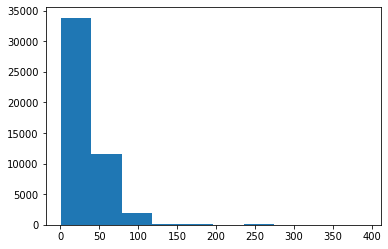

In [148]:
# ge the length of each token
def sequence_len_dist(col):
    length = products[col].fillna('no values').loc[X_train_idx].apply(lambda x: len(str(x).split(' ')))
    # plot the distribution of the word length of each row of product description
    plt.hist(length.values)
    plt.show()

sequence_len_dist('clean_product_descr')

### `brand_name` embedding




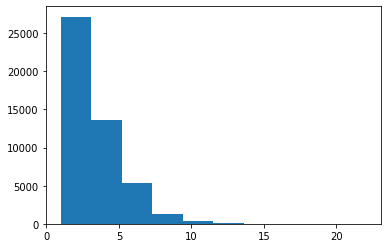

In [149]:
# compute the word length of each brand
sequence_len_dist('brand_name')

In [150]:
# Extract train embedding and test embedding
brand_name_train = products['clean_brand_name'].loc[X_train_idx]
brand_name_test = products['clean_product_descr'].loc[X_test_idx]

productdesc_clean_train = products['clean_product_descr'].loc[X_train_idx]
productdesc_clean_test = products['clean_product_descr'].loc[X_test_idx]

In [151]:
# for brand name 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# tagging documents
documents = [TaggedDocument(str(doc).lower().strip(), [idx]) for idx, doc in list(zip(X_train_idx, brand_name_train.tolist()))]

# train a new doc2vec model
model_brand_name_clean = Doc2Vec(documents, vector_size=6, window=3, workers=4, seed=24,alpha=0.025,epochs=20)

In [152]:
# for product description

# tagging documents
documents = [TaggedDocument(str(doc).lower().strip(), [idx]) for idx, doc in list(zip(X_train_idx, productdesc_clean_train.tolist()))]

# train a new doc2vec model
model_product_descr_clean = Doc2Vec(documents, vector_size=200, window=6, min_count=2, workers=4, seed=24,alpha=0.025,epochs=20)

In [153]:
from nltk import word_tokenize

# infer the unseen product descr and brand name vector from trained genism doc2vec model 
def infer_vector(docs, model):
    vector = []
    for doc in docs:
        tokens = word_tokenize(doc)
        vec = model.infer_vector(tokens)
        vector.append(vec)
    return np.array(vector)

brand_name_test_vec = infer_vector(brand_name_test, model_brand_name_clean)
productdesc_test_vec = infer_vector(productdesc_clean_test, model_product_descr_clean)

In [154]:
# extract the trained doc2vec embedding of product_descr and brand_name
def get_trained_vec(train_index, model):
    vector = []
    for index in train_index:
        vector.append(model[index])
    return vector

brand_name_trained_vector = get_trained_vec(X_train_idx, model_brand_name_clean)
product_descr_trained_vector = get_trained_vec(X_train_idx, model_product_descr_clean)

In [160]:
train_embedding = np.concatenate((np.array(product_descr_trained_vector),
                                  np.array(brand_name_trained_vector)), 
                                 axis = 1)

test_embedding = np.concatenate((np.array(productdesc_test_vec),
                                  np.array(brand_name_test_vec )), axis = 1)

# Check if sum of rows from two embedding match the original datasets
assert train_embedding.shape[0] + test_embedding.shape[0] == products_varaibles.shape[0]

In [162]:
from sklearn.metrics.pairwise import cosine_similarity

# how does test1 doc and test2 looks like 
def test_embedding_func(test1:int, test2:int, df):
    print('test doc1: ', products['brand_name'][test1])
    print('test doc2: ', products['brand_name'][test2])
    
    # do cos sine similarity
    print('The cosine sim of test 1 and 2 is: ',
          cosine_similarity(df.iloc[test1].values.reshape(1,-1), df.iloc[test2].values.reshape(1,-1)))

# if two constrastingly different document get an extremely lower or negative score, then it proves the word embedding sucessful
test_embedding_func(8086, 11921, pd.DataFrame(brand_name_test_vec,index=X_test_idx) )

test doc1:  M001 Narrow in Light Indigo Wash 4
test doc2:  Hart
The cosine sim of test 1 and 2 is:  [[-0.5039105]]


In [163]:
# Get the original X variables based on the X_train_idx
train_variable_mat = products_varaibles.loc[X_train_idx].values

test_variable_mat = products_varaibles.loc[X_test_idx].values

In [168]:
# Combind the doc2vec embedding of both cleaned product description & brand name with the feantures engineered by our team
X_train_data = np.concatenate((train_embedding, train_variable_mat), axis = 1)

X_test_data = np.concatenate((test_embedding, test_variable_mat), axis = 1)

In [169]:
# Now Let‘s retrain a new random forest classifier model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## initialize a randomforest classifier
clf = RandomForestClassifier(oob_score = True)

## fit a new randomfoest model
clf.fit(X_train_data ,y_train_clf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [170]:
# make prediction
y_predict = clf.predict(X_test_data)

# Accuracy of our final prediction model
accuracy_score(y_test_clf, y_predict)

0.49796020314711514

- As we can see the out-of-bag score of Rf was around 70%, meaning the Random Forest can generalize well on unseen data during the training process
- Therefore, Random Forest is the option we can go for

In [171]:
clf.oob_score_

0.7696022313344296

- We also try HistGradientBoostingClassifier, a adpated version of Gradient Boosting trees but it is specifically used for multi-classification problem

In [172]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier

# Use Hist Gradient Boosting Classification for multi classes
hgc = HistGradientBoostingClassifier(loss = 'categorical_crossentropy',
                                      learning_rate = 0.01)
hgc.fit(X_train_data, y_train_clf)

HistGradientBoostingClassifier(l2_regularization=0.0, learning_rate=0.01,
                               loss='categorical_crossentropy', max_bins=255,
                               max_depth=None, max_iter=100, max_leaf_nodes=31,
                               min_samples_leaf=20, n_iter_no_change=None,
                               random_state=None, scoring=None, tol=1e-07,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False)

In [173]:
y_predict = hgc.predict(X_test_data)
accuracy_score(y_test_clf, y_predict)

0.591707601365415

We also try AdaBoostClassifier, but the accuracy for AdaBoostClassifier is only around 25%, which is much lower than RandomForestClassifier and HistGrsdientBoostingClassifier, so we would not take it into the final consideration.

In [174]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(learning_rate = 0.01)
adaboost.fit(X_train_data, y_train_clf)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=50, random_state=None)

In [175]:
y_predict = adaboost.predict(X_test_data)
accuracy_score(y_test_clf, y_predict)

0.239447173424361

We also try KNeighborsClassifier, the n_neighbors was set to 51, since we have 50 most common brands, and 1 class for all other brands. The accuracy for KNeighborsClassifier is around 50%, which is pretty close to RandomForestClassifier and HistGrsdientBoostingClassifier, so it is another option we can go for.

In [176]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=51)
neigh.fit(X_train_data, y_train_clf)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=51, p=2,
                     weights='uniform')

In [177]:
y_predict = neigh.predict(X_test_data)
accuracy_score(y_test_clf, y_predict)

0.4907168428940138

# Conduct Cross Validation on Random Forest/ Hist Gradient Boosting Classification/ KNeighborsClassifier


In [178]:
# Combine the train and test index to match the X_combine_test_train_embedding and y_raw for cross validation 
complete_idx_list = list(X_train_idx)
complete_idx_list.extend(list(X_test_idx))

# concatenate two X_train and X_test data
X_combine_test_train_embedding = np.concatenate((X_train_data, X_test_data),axis=0)

# convert combined data back to dataframe
X_combine_test_train_embedding = pd.DataFrame(X_combine_test_train_embedding, index = complete_idx_list).sort_index()

In [179]:
# Conduct cross_val_score on Random Forest Classifer
from sklearn.model_selection import cross_val_score
cross_val_score_clf = cross_val_score(estimator = RandomForestClassifier(), 
                X = X_combine_test_train_embedding, 
                y = y_raw, 
                cv = 5, 
                n_jobs = -1,
                scoring = 'accuracy'
                )
print(cross_val_score_clf)

[0.61585214 0.65723087 0.70701857 0.73024727 0.68293089]


In [180]:
print(f'The average accuracy score for Random Forest Classifer is {round(cross_val_score_clf.mean()*100,2)}%')

The average accuracy score for Random Forest Classifer is 67.87%


In [181]:
# Conduct cross_val_score on Hist Gradient Boosting Classification
hgc_ = HistGradientBoostingClassifier(loss = 'categorical_crossentropy', learning_rate = 0.025)

cross_val_score_hist = cross_val_score(estimator = hgc_, 
                                       X = X_combine_test_train_embedding, 
                                       y = y_raw, cv = 5, 
                                       n_jobs = -1,
                                       scoring = 'accuracy')

print(cross_val_score_hist)

[0.63608359 0.69294813 0.75114478 0.76063608 0.67910075]


In [182]:
print(f'The average accuracy score for Hist Gradient Boosting Classifer is {round(cross_val_score_hist.mean()*100,2)}%')

The average accuracy score for Hist Gradient Boosting Classifer is 70.4%


In [183]:
# Conduct cross_val_score on KNeighborsClassifier
neigh_ = KNeighborsClassifier(n_neighbors=51)

cross_val_score_neigh = cross_val_score(estimator = neigh_, 
                                       X = X_combine_test_train_embedding, 
                                       y = y_raw, cv = 5, 
                                       n_jobs = -1,
                                       scoring = 'accuracy')

print(cross_val_score_neigh)

[0.34160353 0.39680293 0.48480559 0.48447257 0.45786844]


In [184]:
print(f'The average accuracy score for KNeighbors Classifier is {round(cross_val_score_neigh.mean()*100,2)}%')

The average accuracy score for KNeighbors Classifier is 43.31%


# Conclusion

In conclusion, after `Cross Validation` on `RandomForest classifier`, `HistGradientBoosting` classifier and `KNeighbors classifier`, we can see that `HistGradientBoosting classifier` delivers the best performance among all three models. The average accuracy score for `Hist Gradient Boosting Classifer` is **70.4%**. So we choose the `HistGradientBoosting classifier` as our final selected model.

